<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare" data-toc-modified-id="Prepare-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare</a></span></li><li><span><a href="#Base-Metrics" data-toc-modified-id="Base-Metrics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Base Metrics</a></span></li><li><span><a href="#Clean-the-data" data-toc-modified-id="Clean-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean the data</a></span></li><li><span><a href="#Sentiment-Analysis" data-toc-modified-id="Sentiment-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sentiment Analysis</a></span></li><li><span><a href="#Cosine-Similarity" data-toc-modified-id="Cosine-Similarity-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Cosine Similarity</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Credits" data-toc-modified-id="Credits-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Credits</a></span></li></ul></div>

This notebook uses the DATA620 classes' discussions as data and produces base metrics, a sentiment analysis, and a cosine similarity that allows statements to be made about the general nature of our class.

### Prepare

Load the Discussions data and prepare it for computing metrics, sentiment analysis, and cosine similarity.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import nltk

from nltk.tokenize import word_tokenize, sent_tokenize

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from nltk import RegexpTokenizer
from nltk.corpus import stopwords
stop = stopwords.words('english')

from textblob import TextBlob

from collections import Counter
import string
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#Load the Discussions data
#indata =pd.read_csv("DS620_Discussion_Board_Data.csv")
indata = pd.read_csv('final_thread_data_all.csv')

#Combine the discussions' titles with the discussions' content
indata['Combined'] = indata[['Thread_Name', 'Thread_Content']].apply(lambda x: ' '.join(x), axis=1)
indata = indata.drop(indata.columns[0], 1)

indata.head(1)

,Thread_Name,Initial_Post_or_Comment,Author,Response_To,Thread_Content,Combined
0,Uber API Restrictions Controversy,1,Simon Ustoyev,Simon Ustoyev,"I found 2 articles (one siting the other), whi...",Uber API Restrictions Controversy I found 2 ar...


In [3]:
#Create dataframe of the columns needed for text analysis
indata2 = indata.iloc[:,[2,5]]

In [4]:
#This dataframe has a row for each class member (author) that wrote at least one discussion post, or commented on an 
#existing post. There is one row per author, so an author who wrote 10 discussions and 10 replies has a single row
#that combines all their writing.
data = pd.DataFrame(indata2.groupby('Author').agg({'Combined':lambda x: ', '.join(x)}).reset_index())
data.head(2)

,Author,Combined
0,Abdellah Ait Elmouden,Google's monetization of Google Maps API Last ...
1,Amber Ferger,Flight Prices - Skyscanner Access to travel in...


### Base Metrics

Create a base metrics dataframe that captures some basic statistics (number of words, number of characters, average
word length, and number of stopwords) about each author's posts

In [5]:
def avg_word_length(combined):
    words = combined.split()
    avg = sum(len(word) for word in words)/len(words)
    return avg

def stop_words_count(combined):
    count = 0
    words = combined.split()
    stop_words = stopwords.words('english')
    
    for w in words:
        if w in stop_words:
            count = count + 1
    
    return count

base_metrics = data

base_metrics = base_metrics.drop(['Combined'], axis=1)

base_metrics['num_words'] = data.Combined.apply(lambda x: len(str(x).split(' ')))

base_metrics['num_chars'] = data.Combined.str.len()

base_metrics['avg_word_length'] = data.Combined.apply(lambda x: avg_word_length(x)) 

stop_words = stopwords.words('english')
base_metrics['stop_words_count'] = data.Combined.apply(lambda x: stop_words_count(x))

base_metrics = base_metrics.sort_values(['num_words'], ascending=False).reset_index(drop=True) 

print('Metrics for each author, sorted in descending order by number of words')
base_metrics.head()

Metrics for each author, sorted in descending order by number of words


,Author,num_words,num_chars,avg_word_length,stop_words_count
0,Amber Ferger,4081,26115,5.318138,1557
1,Zachary Alexander,3153,19808,5.196306,1266
2,Murat Akyildirim,3054,20217,5.541544,1040
3,Ken Popkin,2774,16308,4.995888,961
4,Subhalaxmi Rout,2741,19485,5.911681,884


In [6]:
base_metrics.tail()

,Author,num_words,num_chars,avg_word_length,stop_words_count
17,Jeremy OBrien,1081,7047,5.579343,345
18,Vanita Thompson,981,6818,5.777888,331
19,Jack Russo,921,5817,5.132135,349
20,Willie Smalls,879,5078,5.014388,282
21,Mia Chen,676,4606,5.718248,235


<I> Base Metric Conclusions: </I>
1. The range in number of words is from 676 to 4081.  This indicates a significant delta in the participation rate for discussions across the class.

2. It's interesting that the average word length doesn't vary much among the class with everyone in a range of 4 to 6 characters.

3. The stop words count appears highly correlated to the number of words, which makes sense.

### Clean the data

In this section we clean the data by moving to lowercase, removing stop words & the most common words, removing URL's, and removing punctuation.  We also add word and sentence tokenized columns.

In [7]:
#Identify the most frequently occurring words across all the authors posts, including stop words
everyones_text = ''
for text in data.Combined:
    everyones_text = everyones_text + ' ' + text.lower()

words = everyones_text.split()
words = Counter(words)
common_words = words.most_common(18)
common_words = [entries[0] for entries in common_words]
print(common_words)

['the', 'to', 'and', 'of', 'a', 'in', 'is', 'for', 'that', 'this', 'i', 'on', 'be', 'with', 'can', 'are', 'as', 'data']


In [8]:
#Functions used below to clean data
def remove_stop_words(inclean):
    stop_words = stopwords.words('english')
    words = inclean.split()
    outclean = ''
    
    for word in words:
        if word not in stop_words:
            outclean = outclean + ' ' + word
    
    return outclean
    
def remove_common_words(inclean):
    words = inclean.split()
    outclean = ''
    
    for word in words:
        if word not in common_words:
            outclean = outclean + ' ' + word
    
    return outclean

def remove_url(inclean):
    outclean = re.sub(r"http\S+", "", inclean) 
    
    return outclean

In [9]:
#Run each author's text thru the cleaning steps below, then add the cleaned data as a new column (combined_clean) to the
#data dataframe, along with word and sentence tokenized columns.
cleandf = data

clean_data_list = []
word_token_list = []
sentence_token_list = []

for text in cleandf.Combined:
    clean = text.lower()     #lower case
    
    clean = remove_stop_words(clean) #remove stop words
    
    clean = remove_common_words(clean) #remove the most common words
    
    clean = remove_url(clean)
    
    clean_data_list.append(clean)
    
    #remove punctuation and tokenize by word
    tokenizer = RegexpTokenizer(r'\w+')
    word_tokens = tokenizer.tokenize(clean)
    word_token_list.append(word_tokens)
    
    #remove punctuation and tokenize by sentence
    translator = str.maketrans('', '', string.punctuation)
    sentence_tokens = sent_tokenize(clean)
    sentence_tokens = [s.translate(translator) for s in sentence_tokens] 
    sentence_token_list.append(sentence_tokens)
    
cleandf['combined_clean'] = clean_data_list
cleandf['word_tokens'] = word_token_list
cleandf['sentence_tokens'] = sentence_token_list

In [10]:
cleandf.head(3)

,Author,Combined,combined_clean,word_tokens,sentence_tokens
0,Abdellah Ait Elmouden,Google's monetization of Google Maps API Last ...,google's monetization google maps api last ye...,"[google, s, monetization, google, maps, api, l...",[ googles monetization google maps api last ye...
1,Amber Ferger,Flight Prices - Skyscanner Access to travel in...,flight prices - skyscanner access travel info...,"[flight, prices, skyscanner, access, travel, i...",[ flight prices skyscanner access travel info...
2,Elina Azrilyan,Managing impacts of data changes The following...,managing impacts changes following article di...,"[managing, impacts, changes, following, articl...",[ managing impacts changes following article d...


### Sentiment Analysis

Assess the sentiment of each author's discussions and add the sentiment as a column in the cleandf dataframe. <br> <br>

From [Analytics Vidyha](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/#:~:text=The%20sentiment%20function%20of%20textblob,1%20means%20a%20negative%20statement.&text=Subjectivity%20is%20also%20a%20float,of%20%5B0%2C1%5D.) the sentiment function of textblob returns two properties, polarity, and subjectivity.  Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

In [11]:
sentiment_list = []

for text in cleandf.combined_clean:
    sentiment = TextBlob(text).sentiment
    sentiment_list.append(sentiment)

cleandf['sentiment'] = sentiment_list
cleandf.head(2)

,Author,Combined,combined_clean,word_tokens,sentence_tokens,sentiment
0,Abdellah Ait Elmouden,Google's monetization of Google Maps API Last ...,google's monetization google maps api last ye...,"[google, s, monetization, google, maps, api, l...",[ googles monetization google maps api last ye...,"(0.13742170949617766, 0.4622282858984986)"
1,Amber Ferger,Flight Prices - Skyscanner Access to travel in...,flight prices - skyscanner access travel info...,"[flight, prices, skyscanner, access, travel, i...",[ flight prices skyscanner access travel info...,"(0.12432405106832042, 0.4866279804245418)"


In [12]:
#Below is the range of sentiment scores for polarity and for subjectivity
sentiment = cleandf.sentiment
sentiment = list(sentiment)

polarity = sorted([i[0] for i in sentiment])
print(f'Polarity values are {polarity}')

print()
subjectivity = sorted([i[1] for i in sentiment])
print(f'Subjectivity values are {subjectivity}')

Polarity values are [0.062194495980210276, 0.07719893742621015, 0.0879208754208754, 0.09643494793494788, 0.09831326249508068, 0.10603092614456244, 0.10856621057513913, 0.12194988973290863, 0.12432405106832042, 0.12991895471347525, 0.13332457225314367, 0.13742170949617766, 0.14432491837664255, 0.14433928571428575, 0.1472027914614121, 0.15431015478985963, 0.15741275899672846, 0.18443309870790792, 0.18936161633326581, 0.19679018445322793, 0.20848260934467835, 0.20877059448488017]

Subjectivity values are [0.38159389816532663, 0.40339039748130656, 0.42469916556873083, 0.4251010101010099, 0.4305732901534429, 0.4392274788703359, 0.4415184847081402, 0.44824730252565304, 0.45109799890621805, 0.45485559678416854, 0.4592513775532642, 0.4622282858984986, 0.46330764151797366, 0.469304152637486, 0.4751523526077097, 0.48083420411006605, 0.4810658533385805, 0.4836786996786997, 0.4853824746681892, 0.4866279804245418, 0.4873755038065384, 0.49367320974191214]


<I> Sentiment Analysis Conclusions: </I> <br>
The subject of sentiment is probably not very relevant for this project as the nature of our class and the Discussion topics are not political in nature or emotional topics.  But, for the sake of practice we included sentiment in our analysis. <br>

Reviewing the polarity values above, it's safe to state that the discussions are generally positive as the range is 0.38 to 0.49 on a scale of -1 to 1 (negative to positive).

### Cosine Similarity

Compare each author's discussions to all the other authors and output a dataframe of the comparisons
based on the cosine similarity.

In [13]:
maindf = cleandf[['Author', 'word_tokens']]
maindf = maindf.rename(columns={'Author':'author'})

tempdf = maindf

mcosine_list = []
for mrow in maindf.values:
    mauthor = mrow[0]
    mtext = mrow[1]
    
    tcosine_list = []
    maxauthor = ''
    maxcosine = 0
    tcosine_list.append(mauthor)
    for trow in tempdf.values:
        tauthor = trow[0]
        ttext = trow[1]
        
        l1 = []
        l2 = []
        
        mset = {w for w in mtext}  
        tset = {w for w in ttext} 
        rvector = mset.union(tset)
        for w in rvector: 
            if w in mset: 
                l1.append(1) 
            else:
                l1.append(0) 
            
            if w in tset:
                l2.append(1) 
            else:
                l2.append(0) 

        c = 0
        # cosine formula  
        for i in range(len(rvector)): 
                c+= l1[i]*l2[i] 
        cosine = round(c / float((sum(l1)*sum(l2))**0.5),2)
        
        #determine who's cosine is the highest (most similar to the author)
        if (cosine != 1):
            if (cosine > maxcosine):
                maxauthor = tauthor
                maxcosine = cosine
        
        tcosine_list.append(cosine)
        
    tcosine_list.append(maxauthor)
    tcosine_list.append(maxcosine)
    mcosine_list.append(tcosine_list)
    
class_list = list(cleandf.Author)
authors_list = ['main'] + class_list + ['max_author'] + ['max_cosine']
cosinedf = pd.DataFrame(data=mcosine_list, columns=authors_list)

cosinedf.head(2)

,main,Abdellah Ait Elmouden,Amber Ferger,Elina Azrilyan,Habib Khan,Jack Russo,Jagdish Chhabria,Jeremy OBrien,Jithendra Seneviratne,Ken Popkin,Mael Illien,Mia Chen,Mikhail Kollontai,Murat Akyildirim,Priya Shaji,Sheryl Piechocki,Simon Ustoyev,Steven Ellingson,Subhalaxmi Rout,Vanita Thompson,Vijaya Cherukuri,Willie Smalls,Zachary Alexander,max_author,max_cosine
0,Abdellah Ait Elmouden,1.0,0.3,0.21,0.22,0.22,0.26,0.22,0.22,0.30,0.27,0.17,0.27,0.29,0.25,0.26,0.23,0.22,0.29,0.23,0.25,0.16,0.28,Amber Ferger,0.30
1,Amber Ferger,0.3,1.0,0.29,0.27,0.26,0.30,0.27,0.29,0.35,0.34,0.22,0.31,0.34,0.32,0.35,0.30,0.28,0.37,0.27,0.32,0.21,0.34,Subhalaxmi Rout,0.37


In [14]:
#Create a dataframe of each author, the author their discussions are most similar to, and the cosine similarity
similarity = cosinedf[['main', 'max_author', 'max_cosine']]
similarity.columns = ['author1', 'author2', 'weight']
similarity.head()

,author1,author2,weight
0,Abdellah Ait Elmouden,Amber Ferger,0.30
1,Amber Ferger,Subhalaxmi Rout,0.37
2,Elina Azrilyan,Sheryl Piechocki,0.31
3,Habib Khan,Murat Akyildirim,0.30
4,Jack Russo,Amber Ferger,0.26


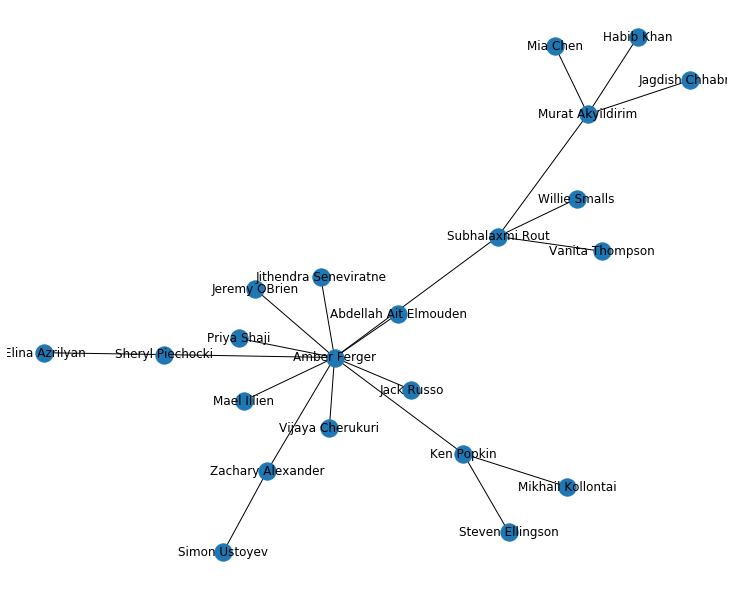

In [15]:
from collections import defaultdict

#Create the graph
node1 = list(similarity.author1)
node2 = list(similarity.author2)
edges = list(similarity.weight)

g = nx.Graph()

#Add nodes
node_ids_list = node1
g.add_nodes_from(node_ids_list)

#Add edges
edges_list = list(zip(node1, node2))
g.add_edges_from(edges_list)

#Generate graph
plt.figure(figsize=(10,8))
g = nx.draw(g, with_labels=True)
plt.show()

<I> Cosine Similarity Conclusions: </I> <br>
Cosine similarity is based on a range of 0 to 1 and for our class the scores ranged from 0.22 to 0.37.  This is a tight range across the class and with everyone's score being below 0.5, it is logical to conclude that we all have very differing writing. <br>
<br>
Keeping the above in mind, it's still interesting to see who's writing is most similar -- Amber's writing style is closest to 8 other class members, followed by Murat's style being closest to 4 other class members.  

Most of the class is only tied to one other class member, which in conjunction with everyone's score being below 0.5, supports that the class writing is not very similar.  Given the nature of the Discussion topics, this is what we would have expected going into this study.
<br>

### Conclusion

<I> What we liked most about this study </I> is being able to use a dataset that we were familiar with, while still being able to apply both the network and text analysis techniques learned throughout the course. Another fun fact is that we had the rare statistical occurrence of being able to make statements about the entire population (our class), rather than just a sample of the data. <br>

<I>Our summary conclusions are that...</I>
1. everyone worked individually on the discussion topics
2. participation rates in responding to the discussions varied widely as shown thru the word counts
3. there is no evidence of teams working together to complete the discussions (similar to point #1, but from a team vantage point)

<I>The above statements are what one would logically expect given that...</I>
1. discussions for this course carry a lower grade weight than assignments & projects
2. responding to the discussion topics, given the wealth of information available at our fingertips, make them reasonably straightforward to complete.

<I>Potentially, a much different result could occur with a different dataset...</I> <br>
For example, a college history class that relied on a series of challenging, take home essays as the primary weight for grades.  Running a dataset like this through our notebooks might reveal very high collaboration (aka, cheating).
<br><br>
<B>Hence a potential use for our work on this project could be to validate authenticity and independent thought in classes where the motivation to collaborate in a negative manner exists.</B>

### Credits

1. [Ultimate Guide to Deal with Text Data](https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/) from Analytics Vidyha  helped to identify base metrics to describe the data and cleaning recommendations to ensure our data was in a ready state for similarity analysis.
<br><br>
2. [What is Text Similarity in NLP,](https://rxnlp.com/what-is-text-similarity-nlp/#.XxDDZihKg2w) proved helpful for understanding lexical similarity and it's application.
<br><br>
3. [StackOverflow link](https://stackoverflow.com/questions/24399820/expression-to-remove-url-links-from-twitter-tweet/24399874) enabled a simple regex means to remove URL's.
<br><br>
4. [geeksforgeeks.org link](https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/) provided a means to calculate cosine similarity